In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


"""
Data Preparation
Load the dataset and clean it
"""


# Load dataset
df = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011")

# Drop rows with missing Customer IDs
df = df.dropna(subset=['Customer ID'])

# Remove canceled transactions (negative quantities)
df = df[df['Quantity'] > 0]

# Create a new feature: Total Sales per transaction
df['TotalSales'] = df['Quantity'] * df['Price']

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Display cleaned data
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [106]:
"""
Feature Engineering
We will use RFM Analysis (Recency, Frequency, Monetary) for clustering:

Recency: How recently a customer made a purchase.
Frequency: How often they make purchases.
Monetary: How much they spend in total.

"""

# Define snapshot date (most recent transaction)
snapshot_date = df['InvoiceDate'].max()

# Compute RFM values per customer
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency (unique purchases)
    'TotalSales': 'sum'  # Monetary value
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Display RFM data
rfm.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,325,1,77183.60
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40


In [107]:
"""
Scaling the Data
Since clustering algorithms are sensitive to scale, we normalize the data.

"""

from sklearn.preprocessing import StandardScaler

# Apply log transformation to reduce skewness
rfm_log = np.log1p(rfm)

# Standardize the dataset
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)


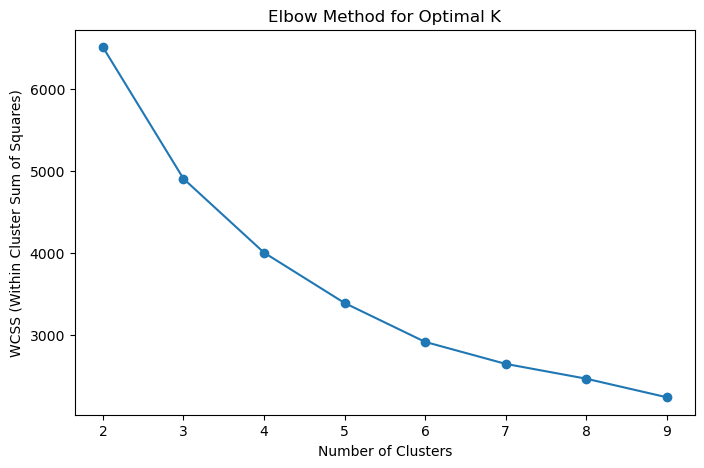

In [108]:
"""
Applying Clustering Algorithms
(K-Means Clustering)

"""
from sklearn.cluster import KMeans

# Find optimal number of clusters using Elbow Method
wcss = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(range(2, 10), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.show()





In [109]:
#Interpretation: The optimal K is where the curve bends (elbow point).

In [110]:
from sklearn.cluster import KMeans

# Define the number of clusters based on the elbow method
optimal_k = 4  

# Run K-Means on the scaled data
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Verify clusters have been assigned
print(rfm['Cluster'].value_counts())  # Check the number of customers in each cluster

Cluster
1    1646
2    1199
3     808
0     686
Name: count, dtype: int64


In [111]:
"""
DBSCAN (Density-Based Clustering)
DBSCAN is useful if there are noise or irregular patterns in data.
"""

from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=1, min_samples=5)
rfm['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_scaled)

# Count customers per cluster
rfm['DBSCAN_Cluster'].value_counts()


DBSCAN_Cluster
 0    4327
-1      12
Name: count, dtype: int64

In [112]:
#Interpretation:

#-1 indicates outliers (noise).
#Other numbers represent different clusters.

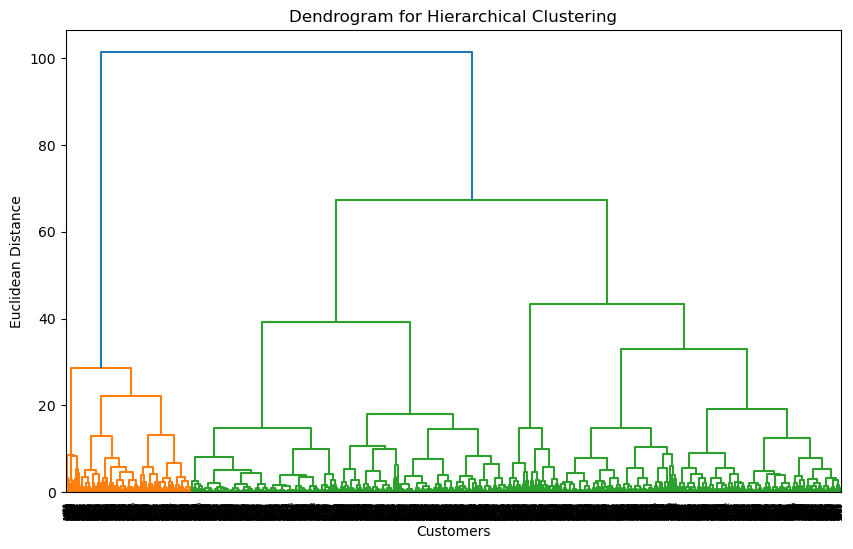

In [113]:
#Hierarchical Clustering

import scipy.cluster.hierarchy as sch

# Create Dendrogram
plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(sch.linkage(rfm_scaled, method='ward'))
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.show()


In [114]:
#Interpretation: The ideal number of clusters is determined by cutting the dendrogram at a suitable height.

/var/folders/g4/y6v5qzbj28lb3__3vvn6prx40000gn/T/ipykernel_11675/1464649011.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=rfm['Cluster'], y=rfm['Monetary'], palette="coolwarm")


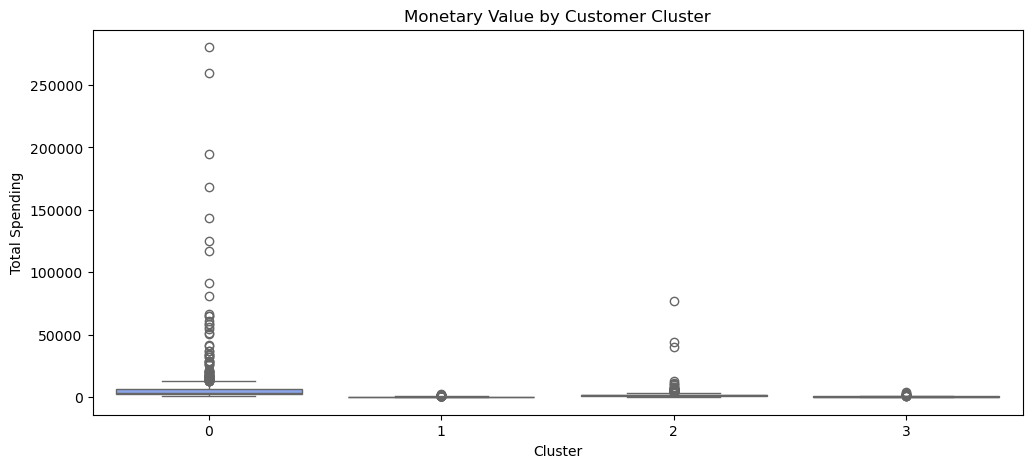

In [115]:
"""
Cluster Visualization
Boxplot for Each Cluster
"""


plt.figure(figsize=(12, 5))
sns.boxplot(x=rfm['Cluster'], y=rfm['Monetary'], palette="coolwarm")
plt.title("Monetary Value by Customer Cluster")
plt.xlabel("Cluster")
plt.ylabel("Total Spending")
plt.show()





In [116]:
#Interpretation:

#High-spending VIP customers are in a separate cluster.
#Low-value customers fall in another cluster.


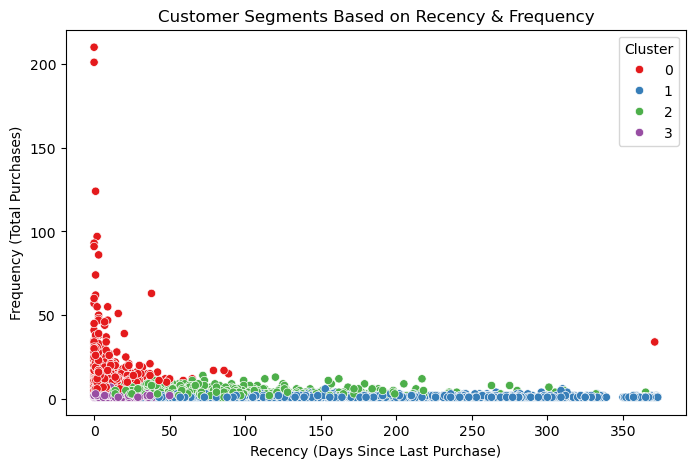

In [117]:
"""
Recency vs Frequency Plot
"""

plt.figure(figsize=(8, 5))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='Set1')
plt.title("Customer Segments Based on Recency & Frequency")
plt.xlabel("Recency (Days Since Last Purchase)")
plt.ylabel("Frequency (Total Purchases)")
plt.show()


In [118]:
#Interpretation:

#Loyal customers have high frequency & low recency (top-left).
#Churning customers have low frequency & high recency (bottom-right).

In [119]:
"""
Business Insights from Clustering
Cluster	    Customer Type	       Strategy
Cluster 0	High-Value VIPs	       Exclusive offers, early access to sales
Cluster 1	Frequent Buyers	       Loyalty programs, cross-sell recommendations
Cluster 2	Occasional Buyers	   Email reminders, discount incentives
Cluster 3	Churning Customers	   Re-engagement campaigns, win-back offers
"""


'\nBusiness Insights from Clustering\nCluster\t    Customer Type\t       Strategy\nCluster 0\tHigh-Value VIPs\t       Exclusive offers, early access to sales\nCluster 1\tFrequent Buyers\t       Loyalty programs, cross-sell recommendations\nCluster 2\tOccasional Buyers\t   Email reminders, discount incentives\nCluster 3\tChurning Customers\t   Re-engagement campaigns, win-back offers\n'